In [277]:
#Audio Processing Libraries
import librosa

#Array Processing
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Display the confusion matrix
from sklearn.metrics import confusion_matrix

#Deal with .pkl files
import pickle

#Create a dataframe
import pandas as pd

#Transform and encode the categorical targets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

#Split dataset
from sklearn.model_selection import train_test_split

#Export the model
import torch.onnx

import os

# import onnx

from numpy.fft import fft
import numpy  as np
import matplotlib.pyplot as plt

import math

# Préparation des données et fonctions

In [2]:
minimum_sr = 16000 #fréquence de récupération des fichiers audio

###### Fonctions de récupération de features

In [2]:
def magnitude(audio,window):
    samples = len(audio)
    power = 0

    while(2**power <= samples):
        power += 1

    power -= 1
    samples = 2**power

#         window = np.hamming(samples)
#         print(sum(window))

    window = window/sum(window)

    np.set_printoptions(precision=4, suppress = True)
    weightedAudio = np.asarray(audio * window)
    for i in range(weightedAudio.size):
        weightedAudio[i] = round(weightedAudio[i],4)
    hN = int((samples/2))                                            # size of positive spectrum, it includes sample 0
    hM1 = int(math.floor((window.size+1)/2))                     # half analysis window size by rounding
    hM2 = int(math.floor(window.size/2))                         # half analysis window size by floor
    fftbuffer = np.zeros(samples)                                 # initialize buffer for FFT
    fftbuffer[:hM1] = weightedAudio[hM2:]                              # zero-phase window in fftbuffer
    fftbuffer[-hM2:] = weightedAudio[:hM2]

    fftAudio = fft(fftbuffer)

    absX = abs(fftAudio[:hN]) # compute ansolute value of positive side
    absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
    mX = 20 * np.log10(absX)

    return mX[:len(mX)]

In [279]:
def mel(magnitudes, nb_filters, window_size):
#     mels = []
#     for fft in fftBatch :
    pow_frames = ((1.0 / window_size) * ((np.asarray(magnitudes)) ** 2))  # Power Spectrum

    #Calcul de la mel scale
#         nfilt = nfilt #correspond à quoi ? au nombre de "bins"/filtres triangulaires que l'on veut ? (32 ou 64 ici ?)
    scale = np.empty(nb_filters)
    signalSample = 4100 #4100Hz le signal PCM
    nqyst = int(signalSample/2)
    melScale = 2595*math.log10(1+nqyst/700)
    scale[0] = 0
    for i in range(1,nb_filters):
        scale[i] = i*melScale / (nb_filters-1)

    #Calcul de l'échelle correspondante en hertz
    hz_points = (700 * (10**(scale / 2595) - 1))
#         print(hz_points.shape)
#         print(hz_points)

    #Création des "bin" ?
    bins = np.floor((window_size + 1) * hz_points / signalSample)
    
    fbank = np.zeros((nb_filters, int(np.floor(window_size / 2))))#+ 1))))
    #(32,128)
    for m in range(1, nb_filters - 1):
        #1 à 30
        f_m_minus = int(bins[m - 1])   # left
        f_m = int(bins[m])             # center
        f_m_plus = int(bins[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    return filter_banks
#     if(len(fftBatch)>1):
#         return mels
#     return mels[0]

In [4]:
def fft_extractor(audios, window):
    ffts = []
    for audio in audios :
            
        ffts.append(magnitude(audio, window))
            
    return ffts

In [170]:
def mel_frames_extractor(audios, nb_filters, window_size = 256, hop_length = 128):
    window = np.hamming(window_size)
    ffts = []
    for audio in audios :
        fftsLocal = []
        n = int(len(audio)/hop_length)
        for i in range (n-1):
            signal = audio[i*hop_length:i*hop_length+window_size]
            fftsLocal.append(magnitude(signal, window))
#         ffts.append(fftsLocal)
        ffts.append(mel(fftsLocal, nb_filters=nb_filters, window_size = window_size))
    return ffts

In [6]:
def mel_extractor (audios, nb_filters = 64, window_size = 2048):
    
    window = np.hamming(window_size) #2048 sans fenêtre glissante, sinon 256
    
    mels = []
    for audio in audios :
        mag = magnitude(audio, window)
        mels.append(mel(mag, nb_filters, window_size))
    return mels

In [7]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):
#     print(len(samples))
    stride_size = 128#int(0.001 * sample_rate * stride_ms)
    window_size = 256#int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, 256)#(len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

#     print(windows.shape)
#     fft = fft_extractor(windows)
#     print(len(fft))

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
#     print(fft.shape)

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [8]:
def spec_extractor (audios):
    spectrograms = []
    for audio in audios :
#         powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(audio, Fs=4000, mode='magnitude')
#         print(powerSpectrum)
#         print(imageAxis)
        spectrograms.append(spectrogram(np.asarray(audio), 4100, max_freq=32000))
    return spectrograms

In [25]:
signal = [-126, -142, -133, -130, -129, -124, -111, -114, -120, -116, -86, -93, -88, -105, -87, 73, 73, 68, 71, 54, 74, 91, 103, 116, 142, 169, 190, 208, 220, 238, 239, 244, 241, 217, 213, 201, 194, 190, 177, 170, 144, 139, 126, 107, 96, 95, 103, 106, 88, 59, 36, 15, 100, 84, 85, 76, 86, 85, 75, 76, 91, 109, 152, 165, 187, 200, 233, 235, 253, 239, 244, 232, 224, 214, 206, 190, 190, 183, -90, -83, -96, -75, -55, -47, -28, -31, -13, -24, -34, -14, -15, -17, -21, -33, -14, -9, -2, -5, -9, -2, -13, -1, -7, -9, 9, -1, 17, 30, -110, -90, -79, -72, -57, -58, -71, -62, -68, -71, -74, -95, -89, -68, -59, -70, -95, -99, -108, -113, -88, -62, -47, -32, -26, -12, -2, 1, -3, 6, -4, -1, 5, 5, -40, -40, -35, -26, -26, -4, -6, -4, -8, 0, 8, 16, 6, -7, -28, -40, -38, -41, -37, -22, -19, -12, -17, -33, -24, -5, 26, 26, 35, 186, 179, 156, 143, 134, 106, 99, 73, 51, 44, 53, 56, 70, 53, 53, 24, 34, 29, 35, 28, 24, 18, 24, 11, 12, 9, 3, -15, -14, -27, -18, -44, -52, -72, -62, -59, -63, -53, -36, -36, -21, -25, -20, 1, 13, 19, 51, 50, 50, 37, 6, -8, -34, -31, -50, -59, -66, -57, -35, -42, -61, -57, -70, -88, -107, -52, -68, -83, -106, -113, -123, -154, -164, -160, -160, -168, -151, -148, -148, -149, -153, -168, -224, -223, -237, -242, -247, -236, -217, -202, -185, -192, -189, -202, -206, -206, -210, -200, -195, -183, -213, -210, -215, -221, -230, -229, -233, -224, -235, -232, -236, -236, -243, -244, -266, -255, -265, -246, -244, -243, -240, -232, -248, -246, -246, -233, -235, -220, 8, 7, 16, 0, 28, 37, 43, 52, 58, 79, 70, 76, 85, 95, 116, 98, 94, 93, 89, 98, 57, 50, 53, 46, 18, 11, 23, 11, 11, 14, 8, 28, 43, 58, 82, 90, 102, 90, 68, 45, 26, 13, -12, -7, 16, 17, 20, 36, 48, 56, 36, 18, 17, -12, -19, -40, -51, -66, -81, -100, -125, -142, -161, -167, -168, -168, -180, 64, 54, 54, 63, 67, 59, 50, 43, 49, 34, 21, -6, -13, -28, -21, -39, -68, -78, -105, -126, -136, -60, -69, -58, -50, -66, -65, -72, -71, -56, -38, -21, -4, 2, 18, 27, 24, 19, 0, 7, -77, -87, -119, -136, -124, -141, -122, -122, -126, -127, -138, -126, -126, -127, -144, -163, -179, -201, -207, -222, -229, -81, -100, -116, -135, -139, -149, -170, -161, -194, -193, -188, -176, -173, -179, -165, -172, -169, -50, -64, -39, -35, -33, -33, -28, -19, -36, -64, -58, -65, -49, -28, -26, -6, -12, -53, -51, -50, -38, -35, -40, -36, -58, -53, -71, -61, -84, -90, -95, -77, -52, -36, -56, -50, -72, -69, -72, -70, -65, -45, -15, -1, 26, 45, 51, 74, 69, 78, -67, -64, -51, -40, -40, -38, -39, -36, -33, -44, -26, -23, 0, 21, 21, 35, 27, 42, 49, 38, 47, -179, -164, -177, -155, -157, -145, -133, -138, -126, -103, -94, -94, -84, -87, -68, -78, -82, -67, -209, -215, -222, -214, -190, -165, -169, -145, -124, -88, -76, -87, -79, -58, -77, -64, -87, -78, -71, -60, -63, -74, -56, -51, -49, -40, -15, -15, -25, -24, -42, -52, -65, -89, -101, -105, -94, -83, -52, -60, 85, 87, 98, 94, 72, 69, 101, 82, 89, 91, 99, 110, 103, 103, 77, 88, 77, 73, 64, 58, 58, 70, 66, 42, 128, 137, 140, 136, 113, 85, 67, 39, 76, 71, 77, 80, 81, 101, 104, 121, 137, 137, 127, 126, 124, 119, 104, 100, 104, 111, 111, 92, 88, 86, 85, 66, 59, -14, -15, -11, -11, -10, -10, -9, 9, 5, 7, 10, 26, 19, 39, 37, 26, 18, 19, 27, 30, 39, 32, 49, 45, 61, 85, 85, 75, 69, 75, -198, -184, -175, -148, -140, -131, -150, -166, -171, -181, -178, -178, -164, -163, -144, -151, -138, -132, -108, -86, -80, -69, -54, -48, -47, -47, -46, -61, -155, -162, -174, -190, -181, -192, -197, -181, -207, -184, -200, -179, -190, -184, -179, -158, -135, -114, -111, -108, -111, 20, 16, 45, 63, 70, 66, 51, 45, 38, 13, 13, -19, -50, -79, -103, -97, -119, -98, -88, -76, -69, -66, -51, -55, -55, -56, -66, -40, -24, 4, 30, 45, 56, 46, 46, 64, 32, 38, 26, 26, 31, 36, 27, 15, 3, 3, -15, 11, 23, -58, -45, -44, -56, -41, -45, -44, -50, -59, -35, -24, -18, -12, 9, 18, 34, 21, 17, 9, -20, -33, -41, -51, -4, -14, -38, -29, -22, -12, 4, 14, 18, -9, -7, -20, -34, -45, -52, -59, -53, -31, -29, -8, -8, 2, -4, 30, 24, 36, 16, -6, -7, -14, 4, 13, 10, 14, 10, 16, 18, 23, 26, 26, 64, 60, 47, 37, 38, 28, 14, -15, -43, -65, -60, -59, -46, -48, -37, -36, -32, -39, -34, -51, -58, -62, -68, -80, -78, -72, -79, -72, -72, -66, -95, -111, -114, -130, -115, -149, -164, -161, -143, -125, -125, -128, -138, -141, -145, -147, -144, -146, -144, -132, -117, -88, -71, -57, -63, -55, -45, -46, -43, -338, -345, -355, -375, -391, -382, -359, -356, -342, -339, -320, -303, -272, -276, -260, -246, -225, -213, -217, -225, -219, 33, 28, 13, -9, -30, -32, -51, -64, -92, -135, -142, -137, -124, -107, -75, -57, -45, -42, -36, -48, -18, -18, -14, -8, 9, 40, 33, 40, 54, 41, 50, 37, 40, 33, 22, 10, -9, -11, -10, -16, -3, 9, 15, 5, 24, 9, -14, -22, 9, 8, 5, -27, -36, -40, -34, -19, -29, -24, -35, -32, -32, -8, -1, -6, -13, -24, -18, -34, -28, -25, -32, -88, -97, -108, -125, -132, -127, -109, -84, -83, -65, -47, -51, -48, -56, -54, -65, -68, -91, -88, -86, -79, -79, -81, -81, -88, -92, -85, -81, -100, -107, -114, -94, -100, -97, -107, -123, -43, -38, -33, -54, -48, -55, -41, -22, -24, -51, -64, -80, -87, -98, -113, -101, -111, -94, -94, -71, -60, 39, 17, 7, -5, -21, -22, -24, -44, -41, -58, -54, -54, -47, -54, -47, -42, -26, -36, -59, -50, -54, -64, -76, -72, -76, -80, -68, -81, -89, -108, -127, -130, -149, -140, -137, -128, -126, -126, -101, -103, -102, -129, 0, -33, -33, -20, -28, -25, -36, -43, -31, -35, -9, -11, -1, 8, -19, -27, -45, -55, -72, -63, -74, -94, -97, -156, -147, -173, -182, -197, -212, -225, -230, -218, -224, -237, -253, -253, -251, -251, -237, -238, -228, -207, -192, -203, -214, -195, -195, -183, -183, -177, -181, -146, -125, -103, -82, -83, -72, -70, -67, -82, -84, -97, -98, -19, -12, -25, -48, -50, -68, -94, -85, -85, -84, -73, -74, -69, -99, -103, -114, -117, -136, -131, -140, -127, -131, -60, -75, -40, -37, -21, -37, -19, -4, -4, 14, -1, 8, 1, -1, -15, -3, -14, -14, -20, -12, 0, -22, -49, -53, -53, -52, -62, -81, -95, -113, -129, -144, -157, -166, -174, -176, -161, -136, -125, -100, -113, -121, -102, -108, -135, -129, -123, -146, -148, -151, -135, -137, -148, -151, -155, -155, -155, -155, -125, -115, -93, -89, -94, -76, -76, -161, -165, -172, -163, -157, -169, -154, -136, -138, -130, -131, -131, -139, -157, -165, -172, -209, -225, -234, -230, -232, -261, -270, -287, -283, -287, -289, -289, -295, -292, -273, -281, -278, -286, -286, -276, -268, -262, -255, -230, -220, -203, -191, 41, 27, 17, -2, -28, -51, -79, -90, -88, -93, -108, -108, -136, -129, -123, -129, -129, -132, -127, -146, -157, -165, -154, -232, -245, -246, -256, -247, -249, -238, -241, -254, -254, -264, -255, -248, -239, -239, -233, -224, -206, -207, -203, -180, -185, -152, -140, -124, -112, -87, -69, -40, -28, 2, 30, 60, 92, 99, 84, 47, -7, -27, -47, -73, -78, -76, -250, -232, -217, -188, -187, -179, -179, -156, -173, -152, -127, -112, -97, -84, -84, -62, -43, -21, 8, 8, 9, 2, -17, -144, -138, -142, -161, -160, -156, -161, -157, -173, -179, -188, -194, -182, -195, -191, -221, -217, -203, -199, -178, -161, -144, -132, -126, -113, -84, -65, -19, -1, 31, 76, 94, 106, 118, 111, 103, 94, 84, 93, 89, 90, 71, 46, 36, 140, 166, 167, 178, 159, 153, 146, 135, 136, 120, 115, 119, 113, 116, 100, 115, 143, 146, 133, 128, 121, 120, 125, 118, 102, 107, 96, 111, 113, 125, 125, 136, 31, 32, 47, 56, 59, 49, 33, 15, 16, 35, 31, 18, 5, -7, -11, -26, -14, -1, 7, 27, 28, 17, 2, -21, -37, -75, -78, -94, -100, -90, -109, -43, -52, -56, -65, -63, -81, -88, -97, -80, -71, -83, -82, -89, -61, -60, -52, -59, -63, -67, -76, -104, 1, -15, -34, -52, -68, -52, -44, -37, -63, -85, -79, -83, -84, -100, -115, -114, -114, -59, -72, -47, -37, -32, -16, 1, -6, 12, 0, -15, -13, -42, -35, -39, -32, -27, -54, -73, 97, 103, 89, 77, 91, 78, 66, 56, 35, 23, 15, 8, 3, -7, -13, -4, -12, -15, -16, -12, -48, -39, -29, -8, -16, -36, -27, -28, 5, 5, -14, 6, 9, 40, 72, 85, 115, 123, 119, 122, 106, -118, -135, -151, -148, -134, -120, -108, -115, -97, -98, -89, -90, -100, -100, -94, -94, -79, -59, -40, -27, -34, -38, -156, -149, -165, -165, -166, -182, -200, -188, -188, -192, -192, -185, -188, -179, -185, -180, 106, 86, 94, 111, 117, 101, 85, 102, 98, 110, 132, 138, 131, 131, 140, 141, 128, 111, 72, 29, -3, -20, -35, -44, 74, 88, 82, 87, 91, 104, 119, 141, 159, 164, 167, 154, 144, 137, 127, 111, 105, 109, 118, 105, 95, 68, 50, 31, 18, 5, 5, 8, 7, -7, -51, -45, -35, -33, -46, -43, -57, -65, -66, -73, -93, -85, -103, -90, -84, -89, -108, -173, -185, -181, -163, -144, -111, -120, -111, -123, -107, -99, -96, -99, -115, -113, -120, -42, -59, -45, -55, -61, -72, -91, -97, -91, -106, -85, -98, -80, -74, -62, -49, -60, -57, -67, -74, -68, -58, -40, -31, -84, -63, -29, -19, 19, 20, 44, 62, 62, 81, 81, 88, 98, 100, 111, 101, 118, 111, 98, 91, 74, 73, 41, 28, -9, 0, 0, 4, 13, 22, 5, -2, -31, -30, -40, -67, -84, -106, -122, -125, -123, -138, -135, -198, -205, -200, -186, -181, -179, -173, -152, -130, -128, -122, -105, -106, -120, -129, -142, -130, -87, -70, -70, -51, -114, -103, -79, -67, -43, -31, -36, -40, -42, -42, -33, -45, -58, -70, -79, -70, -75, -5, -13, -29, -33, -45, -38, -41, -33, -36, -44, -45, -52, -72, -57, -66, -79, -92, -133, -125, -124, -124, -104, -85, -69, -57, -32, -14, 11, 43, 52, 55, 54, 48, 32, 22, 15, 35, 37, 27, 20, 13, 18, 33, 42, 40, 34, 36, 41, 44, 46, 49, 61, 69, 76, 82, 80, 23, 18, 14, 28, 22, 15, -4, -33, -43, -69, -82, -104, -96, -128, -147, -141, -145, -120, 52, 43, 27, -5, -9, -40, -40, -56, -70, -82, -73, -81, -70, -72, -63, -63, -67, -77, -87, -118, -129, -138, -130, -124, -108, -123, -106, -107, -98, -105, -80, -82, -71, -81, -61, -49, -52, -31, -38, -55, -66, -69, -75, -79, -89, -94, -109, -122, -126, -148, -154, -175, -165, -173, 77, 74, 50, 52, 47, 59, 59, 63, 57, 34, 12, -5, -12, -25, -43, -59, -63, -78, -55, -36, -27, 29, 35, 31, 34, 33, 52, 49, 45, 28, 27, 10, 25, 25, 22, -4, 1, 1, 1, -11, -1, 10, 28, 32, -3, -11, -26, -50, -97, -98, -103, -160, -165, -149, -123, -103, -75, -61, -58, -40, -44, -40, -27, -43, -18, -43, -34, -53, -33, -47, -76, -85, -111, -120, -139, -127, -140, -126, -121, -107, -117, -111, -94, -77, -77, 99, 96, 99, 89, 74, 55, 16, -6, -32, -32, -41, -81, -93, -109, -113, -101, -98, -83, -61, -52, -56, -65, -97, -129, -147, -154, 107, 98, 105, 98, 110, 120, 126, 141, 128, 112, 80, 51, 44, 18, -8, -24, -18, -21, -27, 1, 22]
adios = [signal]

2048


In [9]:
numberOfFeatures = 15

def features_extractor_from_audios(audios):
    mfcc = []
    sample_rate = 4100#16000#minimum_sr
    for audio in audios :
        npaudio = np.asarray(audio).astype(float)
        temp = librosa.feature.mfcc(y=npaudio, sr=sample_rate, n_mfcc=numberOfFeatures, hop_length = 128, n_fft = 256)
        mfcc.append(np.mean(temp.T, axis=0))
    return mfcc

In [10]:
window = 0.26 #1 #0.26 pour avoir 4160 données par exemple; permet de faire un fft sur 4096 données

#sépare les fichiers audios en n audios de longueur window (sec)
def cut_audio_window (audiofile):
    audio, sample_rate = librosa.load(file_name, sr=minimum_sr, res_type='kaiser_fast')
    
    numberOfSamples = int(audio.size/sample_rate)
    
    if(numberOfSamples >= 1): #>= window ?
        #length = audio.size/int(audio.size/sample_rate)
        audios = []
        for n in range (int(numberOfSamples/window)) :
            sample = audio[int(n*(window*sample_rate)) : int((n+1)*(window*sample_rate))-1]
            sample = StandardScaler().fit_transform(sample)
            audios.append(sample)
#             audio_mfcc.append(temp)
        return audios
    return []

In [11]:
nbr_values = 2048
def cut_raw_audio (audio):
    audios = []
#     audio = StandardScaler().fit_transform(audio)
    for n in range(int(len(audio)/nbr_values)-1):
        sample = audio[int(n*nbr_values):int((n+1)*nbr_values)]
        audios.append(sample)
# #         audios.append(audio[int(n*nbr_values):int((n+1)*nbr_values)])
#         somme = sum(sample)
#         mean = int(somme/nbr_values)
#         secondeSomme = 0
#         for j in range(nbr_values) :
#             secondeSomme += abs(sample[j]-mean)**2
#         ecartType = (secondeSomme/nbr_values)**0.5
#         for j in range(nbr_values) :
#             sample[j] = (sample[j]-mean)/ecartType
# #         break
#         audios.append(sample)
    return audios

In [15]:
import scipy.io.wavfile as wav

def get_signal (path):
    signal = []
    if("wav" in path):
        fr, signal = wav.read(path)
        signal = signal.tolist()
    else :
        f = open(path,"r")
        lines = f.readlines()
        for i in range (166,len(lines)-1) : #car les premieres valeurs sont liées à la phase d'adaptation du filtre PDM
                                            #-1 car la dernière valeur peut-être tronquée à cause de l'arrêt brusque de l'enregistrement                                 
            s = lines[i].replace("\n","").replace("\r","")
            if(s!='-' and s!=''):
                signal.append(int(s))
    
    return signal

###### Récupération des features dans les audios

In [9]:
#itérer à travers les audios qui nous intéresse
traffic_dataset_path = '../../datasets/emergencyUS/sounds/traffic/'
contreExemple_dataset_path = '../../datasets/contreExemples/'
sireneFR_dataset_path = '../../datasets/urgenceFR/sons/'

extracted_features = []
audio_to_standardize = []
# no_audio_to_standardize = []

classSiren = "siren"
classOther = "other"

countSiren = 0
countOther = 0

#itère sur les sons TRAFIC US
for file in os.listdir(traffic_dataset_path):
    if file.lower().endswith(".wav"):
        file_name = traffic_dataset_path+file
        
        audioTEMP = cut_audio_window(file_name)
        
        if audioTEMP:
#             for example in audioTEMP :
#                 extracted_features.append([0, classOther, file_name])
#                 audio_to_standardize.append(example)
#                 countOther += 1
            nbr_of_audios = len(audioTEMP)
            for i in range(nbr_of_audios):
                extracted_features.append([0, classOther, file_name+"_"+str(i)+"/"+str(nbr_of_audios)])
                audio_to_standardize.append(audioTEMP[i])
                countOther +=1

#itère sur les sons CONTRE EXEMPLES CUSTOMS
for path in os.listdir(contreExemple_dataset_path):
    for file in os.listdir(contreExemple_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = contreExemple_dataset_path+path+"/"+file
            
            audioTEMP = cut_audio_window(file_name)
        
            if audioTEMP:
                nbr_of_audios = len(audioTEMP)
                for i in range(nbr_of_audios):
                    extracted_features.append([0, classOther, file_name+"_"+str(i)+"/"+str(nbr_of_audios)])
                    audio_to_standardize.append(audioTEMP[i])
                    countOther +=1

#itère sur les sons SIRENES FR
for path in os.listdir(sireneFR_dataset_path):
    for file in os.listdir(sireneFR_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = sireneFR_dataset_path+path+"/"+file
            
            audioTEMP = cut_audio_window(file_name)
        
            if audioTEMP:
                nbr_of_audios = len(audioTEMP)
                for i in range(nbr_of_audios):
                    extracted_features.append([0, classSiren, file_name+"_"+str(i)+"/"+str(nbr_of_audios)])
                    audio_to_standardize.append(audioTEMP[i])
                    countSiren +=1



# print(len(extracted_features))
# print(len(audio_to_standardize))
print("Nbr d'extraits sirènes : "+str(countSiren) + "; pourcentage : "+str(countSiren/len(audio_to_standardize))+"%")
print("Nbr d'extraits autres :"+str(countOther) + "; pourcentage : "+str(countOther/len(audio_to_standardize))+"%")

# standardAudio = StandardScaler().fit_transform(audio_to_standardize)
# standardizedAudio = fft_extractor(standardAudio)
# # no_audio_to_standardize = fft_extractor(audio_to_standardize)

# print(len(standardizedAudio))
# for i in range(len(standardizedAudio)):
#     extracted_features[i][0] = standardizedAudio[i]

NameError: name 'cut_audio_window' is not defined

In [509]:
#load raw arduino data
siren_path = "ext40gain115200baud20minSirenes.rw"
# siren_path = "sireneRP.rw"
# other_path = "20minStageRP.rw"
other_path = "ext40gain115200baud20minAutres.rw"

other_path_int = "int40gain115200baud20minAutres.rw"
siren_path_int = "int40gain115200baud20minSirenes.rw"

other_path_augmented = "scipyAugmentedSoundAutresRP.wav"#"augmentedSoundAutresNicla.wav" #"scipyAugmentedSoundAutresRP.wav"
siren_path_augmented = "scipyAugmentedSoundSirenesRP.wav"#"augmentedSoundSirenesNicla.wav" #"scipyAugmentedSoundSirenesRP.wav"

# siren_path = "sireneNicla.rw"
# other_path = "20minStageNicla.rw"

# siren_path = "sirenePDMNV.rw"
# other_path = "silencePDMNV.rw"


extracted_features = []
audio_to_standardize = []
# no_audio_to_standardize = []

classSiren = "siren"
classOther = "other"

countSiren = 0
countOther = 0

# signalTEMP = get_signal(siren_path)
# audioTEMP = cut_raw_audio(signalTEMP)
# nbr_of_audios = len(audioTEMP)
# for i in range(nbr_of_audios):
#     extracted_features.append([0, classSiren, siren_path+"_"+str(i)+"/"+str(nbr_of_audios)])
#     audio_to_standardize.append(audioTEMP[i])
#     countSiren +=1
    
signalTEMP = get_signal(siren_path_augmented)
audioTEMP = cut_raw_audio(signalTEMP)
nbr_of_audios = len(audioTEMP)
for i in range(nbr_of_audios):
    extracted_features.append([0, classSiren, siren_path_augmented+"_"+str(i)+"/"+str(nbr_of_audios)])
    audio_to_standardize.append(audioTEMP[i])
    countSiren +=1
    
# signalTEMP = get_signal(other_path)
# audioTEMP = cut_raw_audio(signalTEMP)
# nbr_of_audios = len(audioTEMP)
# for i in range(nbr_of_audios):
#     extracted_features.append([0, classOther, other_path+"_"+str(i)+"/"+str(nbr_of_audios)])
#     audio_to_standardize.append(audioTEMP[i])
#     countOther +=1
    
signalTEMP = get_signal(other_path_augmented)
audioTEMP = cut_raw_audio(signalTEMP)
nbr_of_audios = len(audioTEMP)
for i in range(nbr_of_audios):
    extracted_features.append([0, classOther, other_path_augmented+"_"+str(i)+"/"+str(nbr_of_audios)])
    audio_to_standardize.append(audioTEMP[i])
    countOther +=1
    
print("Nbr d'extraits sirènes : "+str(countSiren) + "; pourcentage : "+str(countSiren/len(audio_to_standardize))+"%")
print("Nbr d'extraits autres :"+str(countOther) + "; pourcentage : "+str(countOther/len(audio_to_standardize))+"%")

window = np.hamming(len(audio_to_standardize[0]))

# fftsize = len(audio_to_standardize[0])

# no_audio_to_standardize = dft(audio_to_standardize, window, fftsize)

# print(audio_to_standardize[0])
standardAudio = StandardScaler().fit_transform(audio_to_standardize)
# print(standardAudio[0])
no_audio_to_standardize = fft_extractor(standardAudio, window)
# no_audio_to_standardize = mel_frames_extractor(standardAudio, nb_filters = 64)
# no_audio_to_standardize = mel_extractor(audio_to_standardize, nb_filters=16, window_size = 2048)


# no_audio_to_standardize = features_extractor_from_audios(audio_to_standardize)
# no_audio_to_standardize = mel_extractor(audio_to_standardize, nb_filters=32, window_size = 2048)
# no_audio_to_standardize = fft_extractor(audio_to_standardize, window)
# no_audio_to_standardize = spec_extractor(audio_to_standardize)
# no_audio_to_standardize = mel_frames_extractor(audio_to_standardize, nb_filters = 64)


for i in range(len(no_audio_to_standardize)):
    extracted_features[i][0] = no_audio_to_standardize[i].tolist()

Nbr d'extraits sirènes : 2869; pourcentage : 0.5564391000775796%
Nbr d'extraits autres :2287; pourcentage : 0.4435608999224205%


In [510]:
len(extracted_features[0][0])

1024

#### Enregistrer les features récupérées

In [511]:
# f = open('./2048_FFT_magnitude_from_16kHz_audios.pkl', 'wb') #en gros 1/4 de secondes d'un extrait à 16 000 Hz
# f = open('./2048_raw_PCM_from_16kHz_audios.pkl', 'wb')
# f = open('./2048_FFT_PCM_from_16kHz_audios.pkl', 'wb')
# f = open('./1024_FFT_PCM_from_16kHz_audios.pkl', 'wb')
# f = open('./2048_raw_PDM_NiclaVoice.pkl', 'wb')

f = open('./2048_FFT_fonction_Thomas.pkl','wb')

pickle.dump(extracted_features, f)
f.close()

###### Charger des features enregistrées dans un dataframe

In [512]:
# f = open('./2048_FFT_magnitude_from_16kHz_audios.pkl', 'rb')
# f = open('./2048_raw_PCM_from_16kHz_audios.pkl', 'rb')
# f = open('./2048_FFT_PCM_from_16kHz_audios.pkl', 'rb')
# f = open('./1024_FFT_PCM_from_16kHz_audios.pkl', 'rb')
# f = open('./2048_raw_PDM_NiclaVoice.pkl', 'rb')

f = open('./2048_FFT_fonction_Thomas.pkl','rb')

Data = pickle.load(f)
f.close()

In [513]:
#transformation des données sous forme de DataFrame
df = pd.DataFrame(Data,columns=['feature','class','file'])
df.head()
print(df.shape)

(5156, 3)


In [286]:
# print(df['feature'][5181])

###### Séparation des données en train et test

In [514]:
#diviser les données en train et test
X = np.array(df['feature'].tolist(), dtype="float32")

Y = np.array(df['class'].tolist())

file = np.array(df['file'].tolist())

#encoder les labels
labelencoder = LabelEncoder() #permet de transformer les labels string en valeurs numériques
y = torch.tensor(labelencoder.fit_transform(Y))

#séparation en train et test, le random_state permet d'avoir une répartition retrouvable en fonction de l'int
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)

print(X_train.shape)
print(X_test.shape)

torch.Size([4124, 1024])
torch.Size([1032, 1024])


###### Création de Dataset train et test

In [515]:
#création de dataset train/test
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

In [516]:
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

#création de data loader pour choisir facilement le batch size
batch_size=24 #14 pour 518 #17 pour 1037 #21 pour le big dataset et pour 8295 #23 7981 #24 1032 #31 2015

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle = True, num_workers = 0, drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle = False, num_workers = 0, drop_last = True)

## Entrainement des modèles et métriques d'évaluation

In [517]:
def train(model, batch_size=batch_size, weight_decay=0.0, learning_rate=0.001, num_epochs=100):
    
    #les données à entraîner
    dataloader = train_loader
    
    # la loss 
    criterion = nn.BCELoss()
    
    # l'optimiseur
    optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for batch, (features, labels) in enumerate(dataloader):
            if (features.shape[0]==batch_size):#à enlever plus tard, permet d'ignorer les batchs pas pleines
                model.train() # met le modèle en mode train
                
                out = model(features)

                loss = criterion(out.float(), labels.view_as(out).float())

                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

                # sauvegarde iteration et loss
                iters.append(n)
                losses.append(float(loss)/batch_size)             # loss moyen

#                 print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

                if n % 20 == 0 :
                    train_acc.append(get_accuracy(model,train=True)) # training accuracy 
                    model_acc = get_accuracy(model,train=False)
                    val_acc.append(model_acc)  # test accuracy
                    iters_acc.append(n)

                n += 1
            
    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [518]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        if (inp.shape[0]==batch_size):#à enlever plus tard, permet d'ignorer les batchs pas pleines
            output = model(inp) # pas besoin de torch.softmax
            pred = output
            pred[:]=(pred[:]>0.5).float()*1
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += inp.shape[0]
    return correct / total

# Apprentissage MLP Pytorch

In [519]:
class MLP(nn.Module):
    
    def __init__(self, num_hidden=10):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(1024,num_hidden)
#         self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden,1)
        self.num_hidden = num_hidden
        self.sigmoid = nn.Sigmoid()
        self.batch = nn.BatchNorm1d(1)

    def forward(self, x): 
        norm = self.batch(x)
        out = self.layer1(norm)
        out = F.relu(out)
#         out = self.layer2(out)
#         out = F.relu(out)
        out = self.layer3(out)
        out = self.sigmoid(out)
        return out

In [531]:
modelMLP = MLP()

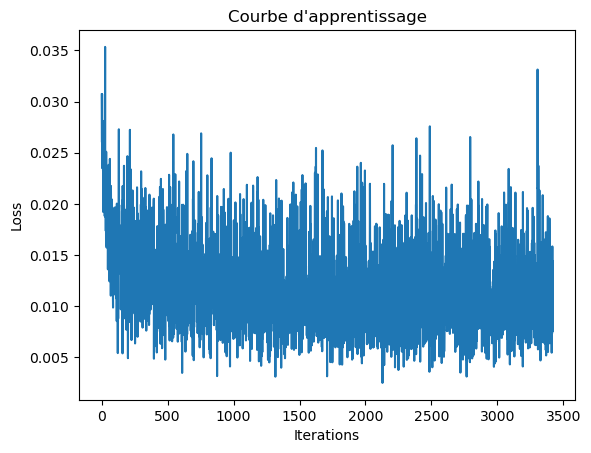

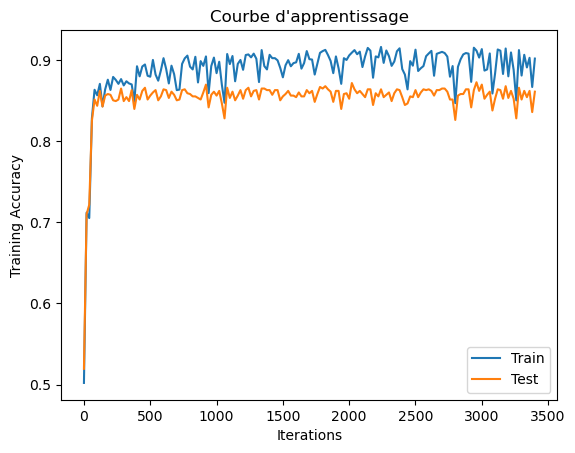

Précision finale Train : 0.9022904483430799
Précision finale Test : 0.8614341085271318


In [532]:
train(modelMLP, weight_decay=0.05, learning_rate=0.001, num_epochs = 20)

# Apprentissage CNN Pytorch

In [181]:
def train(model, batch_size=batch_size, weight_decay=0.0, learning_rate=0.001, num_epochs=100):
    
    #les données à entraîner
    dataloader = train_loader
    
    # la loss 
    criterion = nn.BCELoss()
    
    # l'optimiseur
    optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for batch, (features, labels) in enumerate(dataloader):

            model.train() # met le modèle en mode train
            
            out = model(features)
            
            loss = criterion(out.float(), labels.view_as(out).float())
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen
            
            #print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

            if n % 20 == 0 :
                train_acc.append(get_accuracy(model,train=True)) # training accuracy 
                model_acc = get_accuracy(model,train=False)
                val_acc.append(model_acc)  # test accuracy
                iters_acc.append(n)

            n += 1
            
    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [182]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output
        pred[:]=(pred[:]>0.5).float()*1
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

In [480]:
#CNN (à tester et améliorer)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=8,
                               kernel_size=3,
                               )
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3,
                               )
        self.bn2 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(192, 10) #(16*2*6);16*30*62
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        # Convolution 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
#         print(x.shape)
        
        x = x.view(20, 192) # (16*2*6) 1024 magnitudes fenêtres de 256;(31, 16*30*62) pour 1024 magnitudes sans fenêtre glissante
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

In [481]:
modelCNN = CNN()

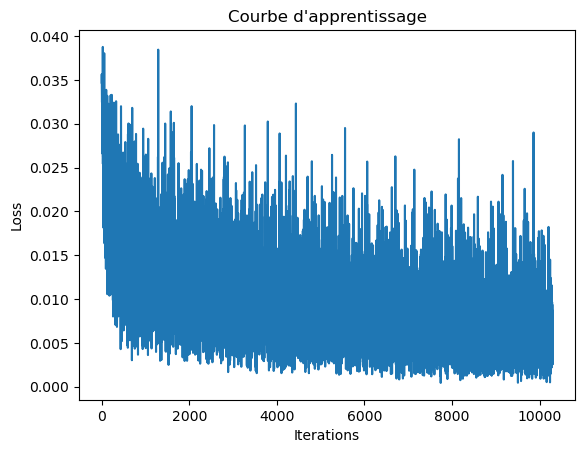

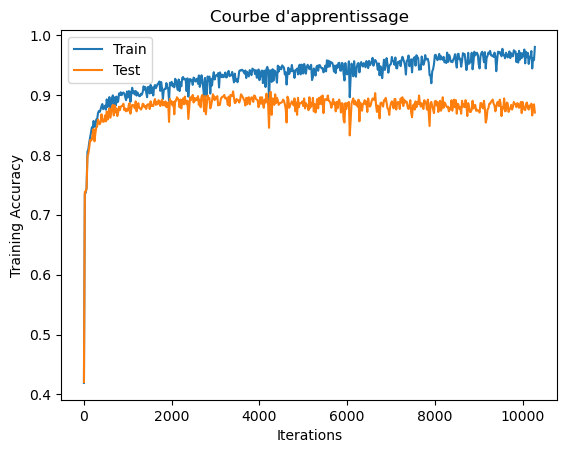

Précision finale Train : 0.9800970873786408
Précision finale Test : 0.8705882352941177


In [482]:
train(modelCNN, weight_decay = 0.01, num_epochs=50)

# Apprentissage MLP Tensorflow (?)

###### Séparation des données en test/train  pour modèle Tensorflow

In [20]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

###### Séparation des données enregistrées en test/train  pour modèle Tensorflow

In [490]:
# f = open('./2048_FFT_magnitude_from_16kHz_audios.pkl', 'rb')
# f = open('./2048_raw_PCM_from_16kHz_audios.pkl', 'rb')
# f = open('./2048_FFT_PCM_from_16kHz_audios.pkl', 'rb')
f = open('./2048_FFT_fonction_Thomas.pkl','rb')

Data = pickle.load(f)
f.close()
#transformation des données sous forme de DataFrame
df = pd.DataFrame(Data,columns=['feature','class','file'])
df.head()
print(df.shape)

(5156, 3)


In [356]:
# def get_dataset_partitions_pd(df, train_split=0.7, val_split=0.1, test_split=0.2):

#     # Specify seed to always have the same split distribution between runs
#     indices_or_sections = [int(train_split * len(df)), int((1 - val_split - test_split) * len(df))]
    
#     train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
#     return train_ds, val_ds, test_ds

In [357]:
# train_dataset, val_dataset, test_dataset = get_dataset_partitions_pd(df)

# print(train_dataset)

In [491]:
#mélange du dataframe suivant un int seed pour avoir toujours le même mélange
df_sample = df.sample(frac=1, random_state=0)

#création du dataset tensorflow avec les labels encodés
labels = df_sample['class']
labels = LabelEncoder().fit_transform(labels)
numeric_features = df_sample['feature']
for i in range(numeric_features.shape[0]):
    numeric_features[i] = np.asarray(numeric_features[i]).astype('float32')
    
numeric_features = np.array([np.array(val) for val in numeric_features])

numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, labels))

In [492]:
#séparation du dataset en dataset de train et de test
percentage = int(len(numeric_dataset)*0.2) + 1
print(percentage)
test_dataset = numeric_dataset.take(percentage) 
train_dataset = numeric_dataset.skip(percentage)

1032


In [493]:
#création de batches sur les datasets
batch_size = 24 #14 518 #17 1037~ #21 5000~/2016 et 8295 #23 pour 7981 #24 1032 #11 pour 3113
test_batches = test_dataset.batch(batch_size)
train_batches = train_dataset.batch(batch_size)

In [76]:
# dataset_train = Dataset(X_train, y_train)
# dataset_test = Dataset(X_test, y_test)

# #création de data loader pour choisir facilement le batch size
# batch_size=13

# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

###

# train_loader = tf.data.Dataset.from_tensors(X_train, y_train).batch(batch_size)
# test_loader = tf.data.Dataset(X_test, y_test).batch(batch_size)

### CNN Tensorflow

In [456]:
optimizer = tf.keras.optimizers.Adam(
    decay=0.05,
    learning_rate=0.01
)

normalizer = tf.keras.layers.BatchNormalization()

def get_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(15, 64, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        normalizer,
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

### MLP Tensorflow

In [495]:
normalizer = tf.keras.layers.BatchNormalization()

optimizer = tf.keras.optimizers.Adam(
#     decay=0.01,
    learning_rate=0.01
)


def get_mlp_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation ='sigmoid')
      ])

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [496]:
# batch_size = 21
# numeric_batches = numeric_dataset.shuffle(1000).batch(batch_size)

In [505]:
model = get_mlp_model()

In [506]:
model.fit(train_batches, shuffle = 0, epochs=30)

Epoch 1/30
172/172 [==============================] - 0s 731us/step - loss: 0.4186 - accuracy: 0.8055
Epoch 2/30
172/172 [==============================] - 0s 743us/step - loss: 0.3617 - accuracy: 0.8354
Epoch 3/30
172/172 [==============================] - 0s 789us/step - loss: 0.3545 - accuracy: 0.8426
Epoch 4/30
172/172 [==============================] - 0s 716us/step - loss: 0.3508 - accuracy: 0.8453
Epoch 5/30
172/172 [==============================] - 0s 700us/step - loss: 0.3475 - accuracy: 0.8465
Epoch 6/30
172/172 [==============================] - 0s 710us/step - loss: 0.3455 - accuracy: 0.8443
Epoch 7/30
172/172 [==============================] - 0s 718us/step - loss: 0.3429 - accuracy: 0.8472
Epoch 8/30
172/172 [==============================] - 0s 721us/step - loss: 0.3408 - accuracy: 0.8448
Epoch 9/30
172/172 [==============================] - 0s 735us/step - loss: 0.3396 - accuracy: 0.8460
Epoch 10/30
172/172 [==============================] - 0s 737us/step - loss: 0.338

In [507]:
# class_names = ['0','1']

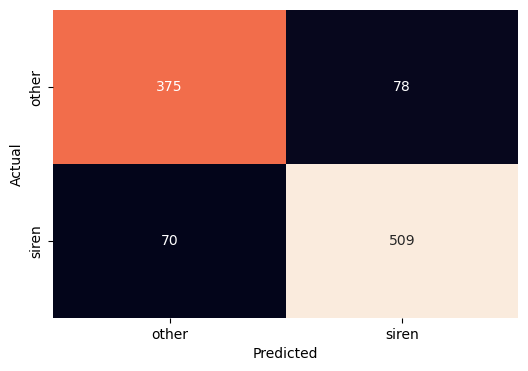

0.8565891472868217 %


In [508]:
y = model.predict(test_batches)

y_pred = []
for _ in y:
    pred = 0
    if(_[0]>=0.5):
        pred = 1
    y_pred.append(pred)
    
# print(next(iter(train_batches))[0][0].label)
y_true = []
for inp, lab in test_dataset :
    y_true.append(lab.numpy())
    
conf_mat = confusion_matrix(y_true,
                            y_pred)

tn, fp, fn, tp = conf_mat.ravel()

labelencoder = LabelEncoder()
y = torch.tensor(labelencoder.fit_transform(['other','siren']))

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(str((tp+tn)/percentage)+" %")

In [449]:
# print(y_pred)

In [144]:
def weights_to_cpp(model, filename="weights_and_biases.txt"):
    model.summary()
    weights = []
    biases = []
    for l in range(len(model.layers)):
        W, B = model.layers[l].get_weights()
        weights.append(W.flatten())
        biases.append(B.flatten())
    
    z = []
    b = []
    for i in np.array(weights):
        for l in i:
            z.append(l)
    for i in np.array(biases):
        for l in i:
            b.append(l)
    with open(filename, "w") as f:
      f.write("weights: {")
      for i in range(len(z)):
        if (i < len(z)-1):
          f.write(str(z[i])+", ")
        else:
          f.write(str(z[i]))
      f.write("}\n\n")

      f.write("biases: {")
      for i in range(len(b)):
        if (i < len(b)-1):
          f.write(str(b[i])+", ")
        else:
          f.write(str(b[i]))
      f.write("}\n\n")
    
      arch = []
    
      arch.append(model.layers[0].input_shape[1])
      for i in range(1, len(model.layers)):
          arch.append(model.layers[i].input_shape[1])
      arch.append(model.layers[len(model.layers)-1].output_shape[1])
      f.write("Architecture: {")
      for i in range(len(arch)):
          if (i < len(arch)-1):
              f.write(str(arch[i])+", ")
          else:
              f.write(str(arch[i]))
      f.write("}")
      print("Architecture (alpha):", arch)
      print("Layers: ", len(arch))
    print("Weights: ", z)
    print("Biases: ", b)


In [500]:
weights_to_cpp(model)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_38 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_79 (Dense)            (None, 10)                170       
                                                                 
 dense_80 (Dense)            (None, 1)                 11        
                                                                 
Total params: 245
Trainable params: 213
Non-trainable params: 32
_________________________________________________________________


ValueError: too many values to unpack (expected 2)

###### Enregistrement du modèle entraîné en TensorflowLite

In [354]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("32MelModel.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("32MelModel.tflite")
print("Model is %d bytes" % basic_model_size)
  
   

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp3i9j88d7\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp3i9j88d7\assets


Model is 3208 bytes


## Création correcte du modèle TFLite, mais pas moyen de créer le header ici.
## Header à créer sur Colab via ce lien https://colab.research.google.com/drive/1HT0kYt1cFgC2lfZwO6sJVotYmjCrqhII#scrollTo=e6de24c5 en copie/collant le modèle TFLite dans Colab

###### Création d'un header arduino à partir du model tflite

In [125]:
# !echo "const unsigned char model[] = {" > /content/model.h
# !cat siren_model.tflite | xxd -i      >> /content/model.h
# !echo "};"                              >> /content/model.h

# import os
# model_h_size = os.path.getsize("model.h")
# print(f"Header file, model.h, is {model_h_size:,} bytes.")
# print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")